# RetinAI_ViT

Diabetic Retinopathy Classifier using BEiT-2, Attention, and a custom head.

## Configuration

In [1]:
import numpy as np
import torch

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

✅ Using device: cuda


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### Model & Training Hyperparameters

In [4]:
MODEL_NAME = 'microsoft/beit-base-patch16-224'
NUM_CLASSES = 5
NUM_EPOCHS = 10
BATCH_SIZE = 32 # Adjust based on your GPU memory
LEARNING_RATE = 1e-5 # Lower learning rate for fine-tuning

## Data Preparation

In [5]:
print(f"Dataset is from https://www.kaggle.com/datasets/amanneo/diabetic-retinopathy-resized-arranged, Download and Extract")
DATA_DIR = '/home/spidey03/Downloads/diabetic-retinopathy-resized-arranged'

Dataset is from https://www.kaggle.com/datasets/amanneo/diabetic-retinopathy-resized-arranged, Download and Extract


In [ ]:
import kagglehub

# Download latest version
# Uncooment below if needs to download the dataset
# DATA_DIR = kagglehub.dataset_download("amanneo/diabetic-retinopathy-resized-arranged")

### Load Image Processor for BeiT model

In [7]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)
image_mean = processor.image_mean
image_std = processor.image_std
image_size = processor.size['height']

### Data Augmentations for Training Set

In [8]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize(mean=image_mean, std=image_std),
])

### Data Transformations for Validation & Test sets

In [9]:
eval_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize(mean=image_mean, std=image_std),
])

### Load Dataset

In [10]:
from torchvision.datasets import ImageFolder

print(f"Loading data from {DATA_DIR}")

full_dataset = ImageFolder(DATA_DIR)
class_names = full_dataset.classes
print(f"Found {len(full_dataset)} images belonging to {len(class_names)} classes.")

Loading data from /home/spidey03/Downloads/diabetic-retinopathy-resized-arranged
Found 35126 images belonging to 5 classes.


### Data Split

In [11]:
from torch.utils.data import random_split

TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.15

train_size = int(TRAIN_SPLIT * len(full_dataset))
valid_size = int(VALID_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

train_subset, valid_subset, test_subset = random_split(
    full_dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(valid_subset)}")
print(f"Test set size: {len(test_subset)}")

Training set size: 24588
Validation set size: 5268
Test set size: 5270


#### Custom Dataset class to Apply correct transformation

In [12]:
from torch.utils.data import Dataset

class DRDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = DRDataset(train_subset, transform=train_transforms)
valid_dataset = DRDataset(valid_subset, transform=eval_transforms)
test_dataset = DRDataset(test_subset, transform=eval_transforms)

#### Handle Class Imbalance with WeightedRandomSampler

In [13]:
from torch.utils.data import WeightedRandomSampler

print("\n⚖️ Addressing class imbalance...")
train_labels = [label for _, label in train_subset]
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[t] for t in train_labels])
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(train_subset),
    replacement=True
)


⚖️ Addressing class imbalance...


#### Create Dataloaders

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("✅ DataLoaders created.")

✅ DataLoaders created.


### Data Architecture

In [15]:
import torch.nn as nn
from transformers import BeitModel

class BEiTForDRClassification(nn.Module):
    def __init__(self, num_classes=5):
        super(BEiTForDRClassification, self).__init__()
        # Load pre-trained BEiT model
        self.beit = BeitModel.from_pretrained(MODEL_NAME)
        
        # --- Freeze most layers ---
        # Unfreeze only the last 2 layers of the encoder for fine-tuning
        for param in self.beit.parameters():
            param.requires_grad = False
        for layer in self.beit.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        hidden_size = self.beit.config.hidden_size

        # --- Attention Mechanism ---
        # This will learn to weigh the importance of different patch embeddings
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8, # A common choice
            dropout=0.1,
            batch_first=True
        )

        # --- Classifier Head ---
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, pixel_values):
        # BEiT forward pass -> outputs patch embeddings
        # Output shape: (batch_size, num_patches + 1, hidden_size)
        outputs = self.beit(pixel_values=pixel_values)
        last_hidden_state = outputs.last_hidden_state

        # Attention mechanism
        # MultiheadAttention expects (query, key, value)
        # We use the same hidden state for all three
        attn_output, _ = self.attention(
            last_hidden_state, last_hidden_state, last_hidden_state
        )

        # We take the output corresponding to the [CLS] token for classification
        # The [CLS] token is the first token in the sequence
        cls_token_output = attn_output[:, 0]

        # Pass through the classifier head
        logits = self.classifier(cls_token_output)
        return logits

print("\n🧠 Initializing model architecture...")
model = BEiTForDRClassification(num_classes=NUM_CLASSES).to(DEVICE)
print("✅ Model initialized and moved to device.")


🧠 Initializing model architecture...
✅ Model initialized and moved to device.


### Training & Fine Tuning

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=2)

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm.auto import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=loss.item())
            
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    return epoch_loss, {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}, all_labels, all_preds

In [19]:
print("\n🚀 Starting model training...")
best_valid_f1 = 0.0
history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_f1': []}

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    valid_loss, valid_metrics, _, _ = evaluate(model, valid_loader, criterion, DEVICE)
    history['valid_loss'].append(valid_loss)
    history['valid_f1'].append(valid_metrics['f1'])
    
    print(f"Epoch {epoch+1} | Valid Loss: {valid_loss:.4f} | Valid F1: {valid_metrics['f1']:.4f} | Valid Acc: {valid_metrics['accuracy']:.4f}")

    scheduler.step(valid_loss)

    # Model Checkpointing
    if valid_metrics['f1'] > best_valid_f1:
        best_valid_f1 = valid_metrics['f1']
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✨ New best model saved with F1-score: {best_valid_f1:.4f}")

print("\n🏁 Training finished.")


🚀 Starting model training...

--- Epoch 1/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.5532 | Train Acc: 0.2819


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1 | Valid Loss: 1.3752 | Valid F1: 0.5096 | Valid Acc: 0.4662
✨ New best model saved with F1-score: 0.5096

--- Epoch 2/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.3895 | Train Acc: 0.3752


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2 | Valid Loss: 1.3877 | Valid F1: 0.3707 | Valid Acc: 0.3041

--- Epoch 3/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.3198 | Train Acc: 0.4059


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3 | Valid Loss: 1.3274 | Valid F1: 0.4130 | Valid Acc: 0.3464

--- Epoch 4/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1.2860 | Train Acc: 0.4192


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4 | Valid Loss: 1.3176 | Valid F1: 0.3765 | Valid Acc: 0.3176

--- Epoch 5/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1.2677 | Train Acc: 0.4294


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5 | Valid Loss: 1.2650 | Valid F1: 0.5005 | Valid Acc: 0.4330

--- Epoch 6/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1.2533 | Train Acc: 0.4380


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6 | Valid Loss: 1.2726 | Valid F1: 0.4051 | Valid Acc: 0.3373

--- Epoch 7/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1.2340 | Train Acc: 0.4442


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7 | Valid Loss: 1.2469 | Valid F1: 0.4063 | Valid Acc: 0.3386

--- Epoch 8/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1.2178 | Train Acc: 0.4514


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8 | Valid Loss: 1.2184 | Valid F1: 0.5254 | Valid Acc: 0.4618
✨ New best model saved with F1-score: 0.5254

--- Epoch 9/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1.1942 | Train Acc: 0.4668


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9 | Valid Loss: 1.2538 | Valid F1: 0.4827 | Valid Acc: 0.4132

--- Epoch 10/10 ---


Training:   0%|          | 0/769 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.1947 | Train Acc: 0.4662


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10 | Valid Loss: 1.1775 | Valid F1: 0.5517 | Valid Acc: 0.4888
✨ New best model saved with F1-score: 0.5517

🏁 Training finished.


### Evaluate

In [20]:
import pandas as pd

print("\n📈 Evaluating model on the test set...")

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

test_loss, test_metrics, test_labels, test_preds = evaluate(model, test_loader, criterion, DEVICE)

print("\n--- Final Test Metrics ---")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"F1 Score (Weighted): {test_metrics['f1']:.4f}")
print(f"Precision (Weighted): {test_metrics['precision']:.4f}")
print(f"Recall (Weighted): {test_metrics['recall']:.4f}")

# Per-class metrics
f1_per_class = f1_score(test_labels, test_preds, average=None)
precision_per_class = precision_score(test_labels, test_preds, average=None)
recall_per_class = recall_score(test_labels, test_preds, average=None)

print("\n--- Per-Class Metrics ---")
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})
print(metrics_df)


📈 Evaluating model on the test set...


Evaluating:   0%|          | 0/165 [00:00<?, ?it/s]


--- Final Test Metrics ---
Accuracy:  0.4951
F1 Score (Weighted): 0.5528
Precision (Weighted): 0.6831
Recall (Weighted): 0.4951

--- Per-Class Metrics ---
  Class  Precision    Recall  F1-Score
0     0   0.854690  0.531787  0.655638
1     1   0.105445  0.325333  0.159269
2     2   0.271218  0.359853  0.309311
3     3   0.198020  0.592593  0.296846
4     4   0.303797  0.685714  0.421053


### Confusion Matrix


📊 Generating confusion matrix...


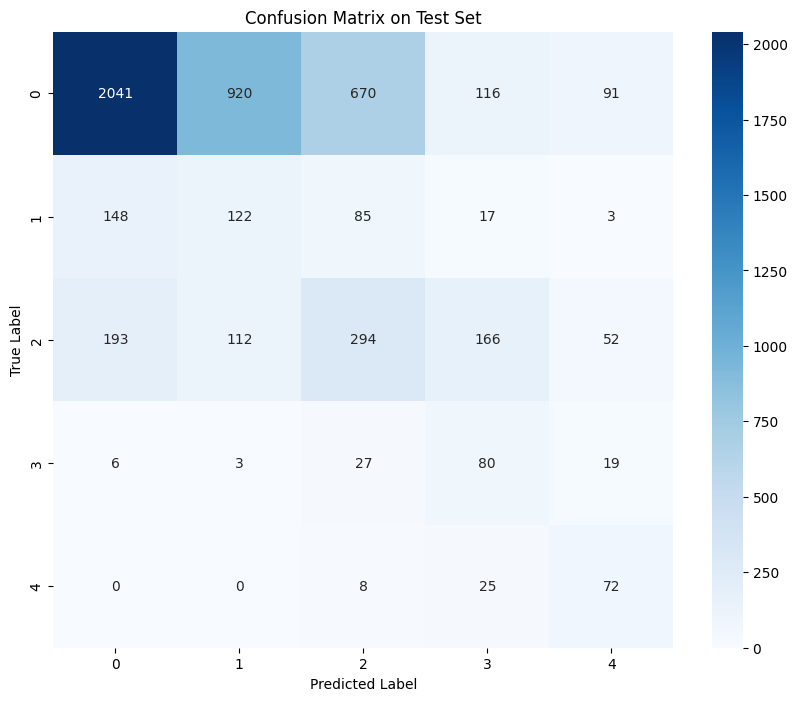

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n📊 Generating confusion matrix...")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Plot Training History


📊 Plotting training history...


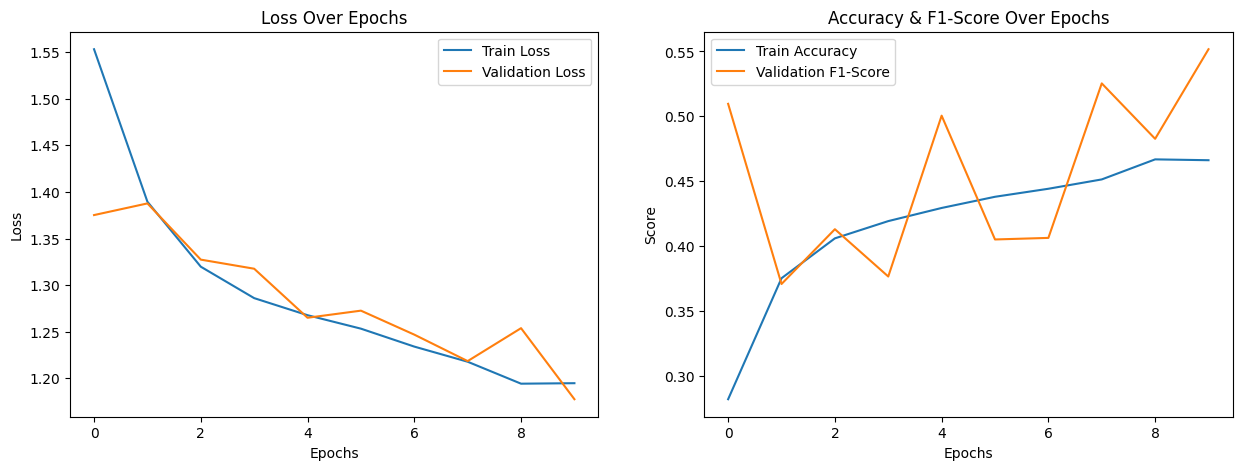

In [22]:
print("\n📊 Plotting training history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['valid_loss'], label='Validation Loss')
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['valid_f1'], label='Validation F1-Score')
ax2.set_title('Accuracy & F1-Score Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()
plt.show()

In [23]:
metrics_df.to_csv("metrics.csv", index=True)